# Model assessment basics

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:,.3f}'.format

def MAPE(y_true, y_pred): # favors estimates below truth
    if np.isclose(y_true,0.0).any():
        return np.nan
    return np.mean(np.abs((y_pred - y_true) / y_true))

def MMAR(y_true, y_pred): # mean max abs ratio
    y_min = np.minimum(np.abs(y_pred), np.abs(y_true)) # if either is zero, inf
    if np.isclose(y_min,0.0).any():
        return np.nan
    if (np.minimum(y_pred, y_true)<0).any():
        return np.nan
    a = np.abs(y_pred/y_true)
    b = np.abs(y_true/y_pred)
    m = np.maximum(a,b)
    return np.mean(m)

def sMAPE(y_true, y_pred):
    # check to ensure neither value is zero at same time
    y_max = np.maximum(np.abs(y_pred), np.abs(y_true))
    if np.isclose(y_max,0.0).any():
        return np.nan
    e = np.abs(y_pred - y_true)
    avg = (0.5 * (np.abs(y_pred) + np.abs(y_true)))
    return np.mean(e / avg)

## Training set metric on random data

In [2]:
X_train = np.random.random((1000,4))
y_train = np.random.random(1000)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.8437727551270587

## NYC rent testing

In [3]:
df_rent = pd.read_json("data/rent-train.json")
features = ['bedrooms', 'bathrooms', 'latitude', 'longitude']
df_rent = df_rent[features+['price']]
X = df_rent.drop('price', axis=1)
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
4,1,1.000,40.711,-73.954
6,2,1.000,40.751,-73.972
9,2,1.000,40.758,-73.963
10,3,1.500,40.715,-73.942
15,0,1.000,40.744,-73.974


In [4]:
df_rent = pd.read_json("data/rent-train.json")
df_rent[['description','features']][2:4]

,description,features
9,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,"[Doorman, Elevator, Laundry in Building, Laund..."
10,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,[]


**Break out 20% hold out validation set**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Train model, compute metrics**

In [6]:
def test():
    rf = RandomForestRegressor(n_estimators=50, oob_score=True, n_jobs=-1)
    rf.fit(X_train, y_train)
    oob = rf.oob_score_ # wow this is a terrible score
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return (oob,r2,mae,mse)
    df_metrics = pd.DataFrame([[oob,r2,mae,mse]],
                              columns=['OOB', 'R^2', 'MAE', 'MSE'])
    print(df_metrics)
#    print(f"{oob:4.2f}, {r2:5.2f}, {mae:5.2f}, {mse:.2f}")

**This error is stable; just variation due to RF**

In [7]:
pd.DataFrame([test() for i in range(3)], columns=['OOB', 'R^2', 'MAE', 'MSE'])

,OOB,R^2,MAE,MSE
0,-0.143,0.013,525.024,"136,776,778.468"
1,-0.355,0.027,498.359,"134,793,205.536"
2,-0.133,0.019,508.899,"136,028,870.368"


**Very unstable if we pick more valid sets**

In [8]:
results = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    results.append( test() )
df_results = pd.DataFrame(results, columns=['OOB', 'R^2', 'MAE', 'MSE'])
df_results

,OOB,R^2,MAE,MSE
0,-0.124,0.025,492.977,"134,783,004.661"
1,0.049,0.044,874.976,"2,063,925,690.033"
2,-0.205,0.814,443.147,"23,202,844.316"
3,-0.232,0.013,590.264,"232,694,070.489"
4,-0.272,-65.760,626.004,"437,232,815.121"


In [9]:
df_results.std()

OOB             0.127
R^2            29.511
MAE           167.548
MSE   844,284,794.152
dtype: float64

**Try k-fold**

In [10]:
k = 5
kf = KFold(n_splits=k, shuffle=True)
results = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    results.append( test() )
df_results_kfold = pd.DataFrame(results, columns=['OOB', 'R^2', 'MAE', 'MSE'])
df_results_kfold

,OOB,R^2,MAE,MSE
0,-0.556,-62.241,604.849,"434,689,138.362"
1,-0.120,0.018,620.622,"234,924,405.897"
2,-0.337,-91.522,570.546,"397,016,699.090"
3,-0.090,0.008,396.572,"5,141,530.740"
4,0.888,0.002,962.429,"2,175,470,556.270"


In [11]:
df_results_kfold.std() # still unstable; try running it multiple times

OOB             0.553
R^2            43.369
MAE           205.699
MSE   869,705,181.221
dtype: float64

In [12]:
k = 5
cvscore = cross_val_score(
			RandomForestRegressor(n_estimators=50), # which model to use
			X_train, y_train, # what training data to split up
			cv=k, # number of folds/chunks
			scoring='neg_mean_absolute_error') # what error metric
-cvscore

array([434.05742385, 390.289233  , 652.28315706, 389.80347328,
       453.44099521])

## Classifiers

In [13]:

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier(n_estimators=30, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

C = confusion_matrix(y_test, y_pred)
C

array([[38,  4],
       [ 0, 72]])

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).flatten()
tn, fp, fn, tp

(38, 4, 0, 72)

In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        42
           1       0.95      1.00      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



## R^2

Text(0.5, 1.0, '$R^2$ = 0.990')

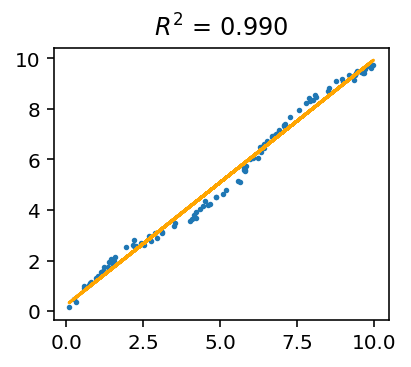

In [16]:
n = 100
x = np.random.random(size=n)*10
y = x + np.sin(x)*.45 + np.random.normal(size=n)*.1
plt.figure(figsize=(3,2.5))
plt.scatter(x,y,s=3)

lm = LinearRegression()
lm.fit(x.reshape(-1,1), y)
y_pred = lm.predict(x.reshape(-1,1))
plt.plot(x, y_pred, c='orange')
plt.title(f"$R^2$ = {lm.score(x.reshape(-1,1),y):.3f}", fontsize=12)

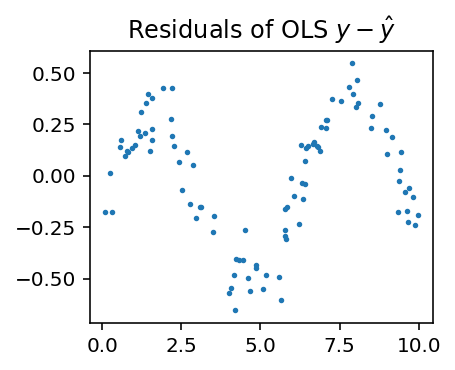

In [17]:
plt.figure(figsize=(3.08,2.5))
plt.scatter(x, y-y_pred, s=3)
plt.title("Residuals of OLS $y - \hat{y}$")
plt.show()

In [18]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)
df

,x,y
0,0.000,0.325
1,1.111,0.432
2,2.222,2.290
3,3.333,1.756
4,4.444,2.515
5,5.556,4.942
6,6.667,5.461
7,7.778,9.122
8,8.889,9.689
9,10.000,10.641


## MAE,MSE

In [19]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)

0.9008248320352714

Text(0.5, 1.0, 'MAE 0.87, MSE 0.97,\nMAPE($y,\\hat{y}$) 0.44, MAPE($\\hat{y}, y$) 0.30')

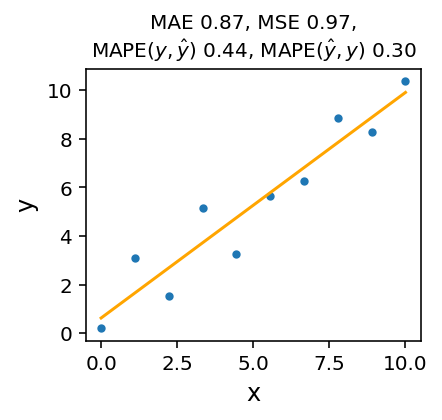

In [20]:
plt.figure(figsize=(3,2.5))
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
y_pred = lm.predict(X)
plt.title(f"MAE {mean_absolute_error(y,y_pred):.2f}, MSE {mean_squared_error(y,y_pred):.2f},\nMAPE($y,\hat{{y}}$) {MAPE(y,y_pred):.2f}, MAPE($\hat{{y}}, y$) {MAPE(y_pred,y):.2f}", fontsize=10)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

In [21]:
y.iloc[-1] = 100

Text(0, 0.5, 'y')

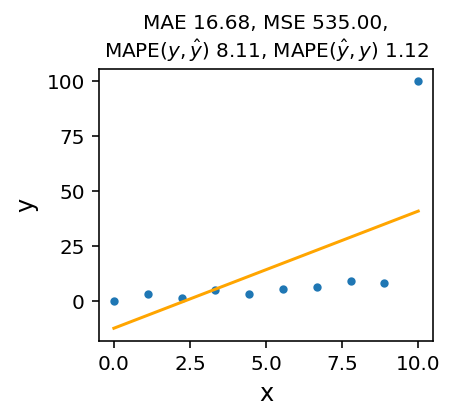

In [22]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"MAE {mean_absolute_error(y,y_pred):.2f}, MSE {mean_squared_error(y,y_pred):.2f},\nMAPE($y,\hat{{y}}$) {MAPE(y,y_pred):.2f}, MAPE($\hat{{y}}, y$) {MAPE(y_pred,y):.2f}", fontsize=10)

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

Text(0, 0.5, 'y')

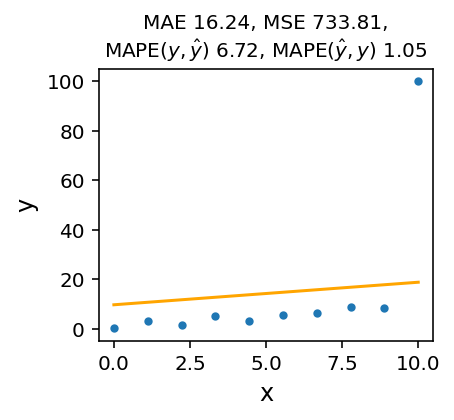

In [23]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = Lasso(alpha=45)
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"MAE {mean_absolute_error(y,y_pred):.2f}, MSE {mean_squared_error(y,y_pred):.2f},\nMAPE($y,\hat{{y}}$) {MAPE(y,y_pred):.2f}, MAPE($\hat{{y}}, y$) {MAPE(y_pred,y):.2f}", fontsize=10)

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

## R^2

In [24]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)

0.9515092560382696

Text(0.5, 1.0, '$R^2$ = 0.952')

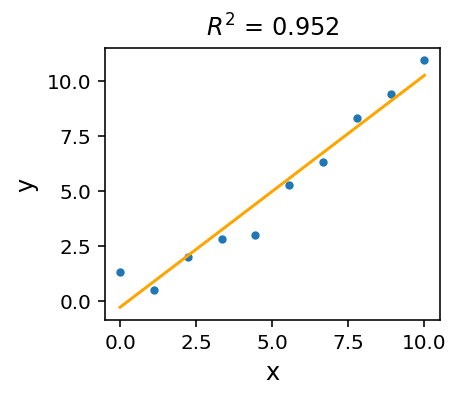

In [25]:
plt.figure(figsize=(3,2.5))
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
y_pred = lm.predict(X)
plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

In [26]:
y.iloc[-1] = 100

Text(0.5, 1.0, '$R^2$ = 0.360')

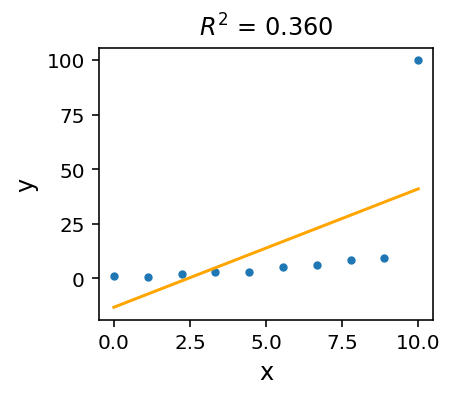

In [27]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

Text(0.5, 1.0, '$R^2$ = 0.121')

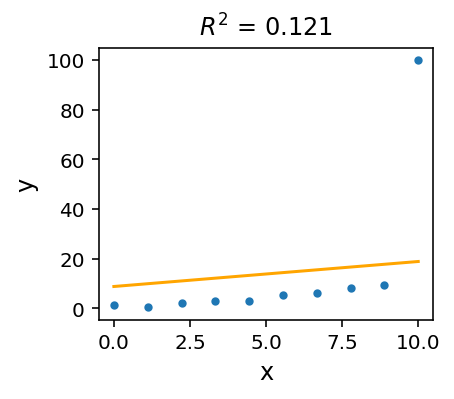

In [28]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = Lasso(alpha=45)
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)

plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

## sMAPE

In [29]:
n = 10
df = pd.DataFrame()
df['x'] = np.linspace(0,10,num=n)
df['y'] = df['x'] + np.random.normal(0,1,size=n)

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)

0.899249881472798

Text(0.5, 1.0, 'sMAPE 0.27')

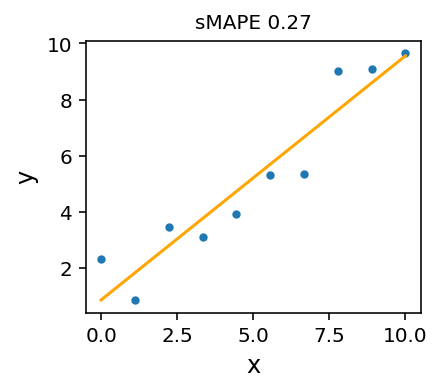

In [30]:
plt.figure(figsize=(3,2.5))
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
y_pred = lm.predict(X)
plt.title(f"sMAPE {sMAPE(y,y_pred):.2f}", fontsize=10)

In [31]:
y.iloc[-1] = 100

Text(0, 0.5, 'y')

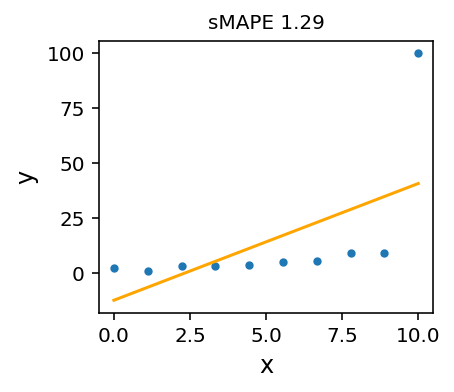

In [32]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = LinearRegression()
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"sMAPE {sMAPE(y,y_pred):.2f}", fontsize=10)
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)

Text(0, 0.5, 'y')

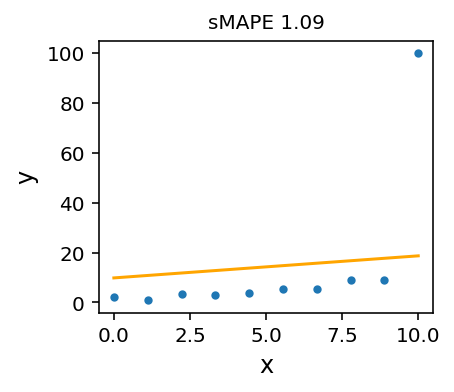

In [33]:
plt.figure(figsize=(3,2.5))

X, y = df.drop('y',axis=1), df['y']
lm = Lasso(alpha=45)
lm.fit(X, y)
beta0 = lm.intercept_
beta1 = lm.coef_[0]
lm.score(X, y)
y_pred = lm.predict(X)
plt.title(f"sMAPE {sMAPE(y,y_pred):.2f}", fontsize=10)
plt.scatter(df['x'], df['y'], s=10)
plt.plot(df['x'], df['x']*lm.coef_[0] + lm.intercept_, c='orange')
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
#plt.title(f"$R^2$ = {lm.score(X,y):.3f}", fontsize=12)